In [1]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr
import meshio
import meshplot as mp
import json
import subprocess
import colorsys

In [2]:
#Helper function for solve() - determines if a float is between two other floats
def is_between(num, n1, n2):
    if (num <= n1 and num >= n2) or (num >= n1 and num <= n2):
        return True
    else:
        return False

    
#function that determines if a point is between two other points on the same segment
def solve(coordinates) -> bool:
    (x0, y0), (x2, y2) = coordinates[0], coordinates[2]
    x1, y1 = coordinates[1]
    if (abs((x0 - x2) * (y2 - y1) - (x2 - x1) * (y0 - y2)) < 0.001) and (is_between(x1, x0, x2) and is_between(y1, y0, y2)):
        return True
    else:
        return False


#Forms lists necessary for further work - inefficient, probably needs some fixing
#This function is specifically for if you're NOT doing dual-side colours
def build_point_lists(v, pts, seg0):
    segment_lines = []
    all_dots = []
    all_dots_indexed = {}
    red_dots = []
    green_dots = []
    segment_green_points = {}
    
    for line in seg0:
        segment_lines.append([v[line[0]], v[line[1]]])

    red_dots = pts
    for d_i in range(len(red_dots)):
        all_dots_indexed[d_i] = red_dots[d_i]

    for p_i in range(len(v)):
        if v[p_i].tolist() not in red_dots:
            for l_i in range(len(seg0)):
                if solve([v[seg0[l_i][0]], v[p_i], v[seg0[l_i][1]]]):
                    green_dots.append(v[p_i].tolist())
                    all_dots_indexed[p_i] = v[p_i].tolist()
                    
    all_dots += red_dots
    all_dots += green_dots
    
    for line_index in range(len(segment_lines)):
        for p_i in range(len(green_dots)):
            if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                if line_index in segment_green_points:
                    segment_green_points[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                else:
                    segment_green_points[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]
    
    return (segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, segment_green_points)

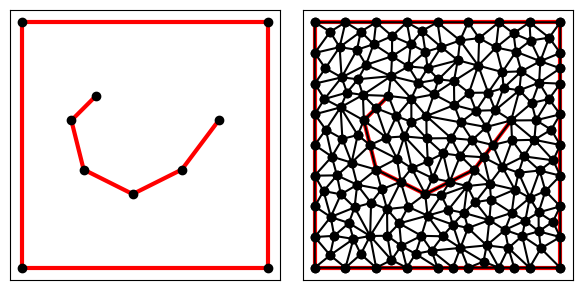

In [3]:
#Forming the object (manually)
pts0 = np.array(((0, 0), (10, 0), (10, 10), (0, 10))) #border
pts1 = np.array(((3, 7), (2, 6), (2.5, 4), (4.5, 3), (6.5, 4), (8, 6)))

pts = np.vstack([pts0, pts1]) #combined

#connecting points together (manually)
seg1 = np.array(((0, 1), (1, 2), (2, 3), (3, 0)))
seg2 = []
for i in range(4, len(pts1) + 3):
    seg2.append((i, i+1))
seg2 = np.array(seg2)
seg_comb = [seg1, seg2]
seg0 = np.vstack(seg_comb)

#indicies where segment meets up with beginning of shape--needed for random colour generation, but not manual
loop_backs = [3]
#indicies where segments are isolated
iso_segs = [8]

A = dict(vertices=pts, segments=seg0)
meshObj = tr.triangulate(A, 'qpa0.5')

shape = (pts, seg0, meshObj, loop_backs, iso_segs)

tr.compare(plt, A, meshObj)

In [4]:
lists = build_point_lists(meshObj['vertices'], pts.tolist(), seg0.tolist())
segment_lines = lists[0]
all_dots = lists[1]
all_dots_indexed = lists[2]
red_dots = lists[3]
green_dots = lists[4]
segment_green_points = lists[5]

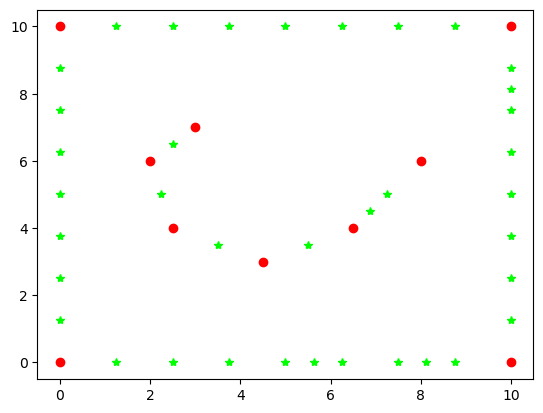

In [6]:
#FOR VIEWING TANGENTS to make sure it works (it works, I'm a fukkin genius)
gx = []
gy = []
for dot in green_dots:
    gx.append(dot[0])
    gy.append(dot[1])
    
rx = []
ry = []
for dot in red_dots:
    rx.append(dot[0])
    ry.append(dot[1])

plt.plot(gx, gy, '*', c=(0,1,0))
plt.plot(rx, ry, 'o', c=(1,0,0))

In [7]:
seg_vs = [k for k, v in all_dots_indexed.items() if v in green_dots]
seg_tris = []
for tri in meshObj['triangles']:
    for v in tri:
        if v in seg_vs:
            seg_tris.append(tri.tolist())
            continue

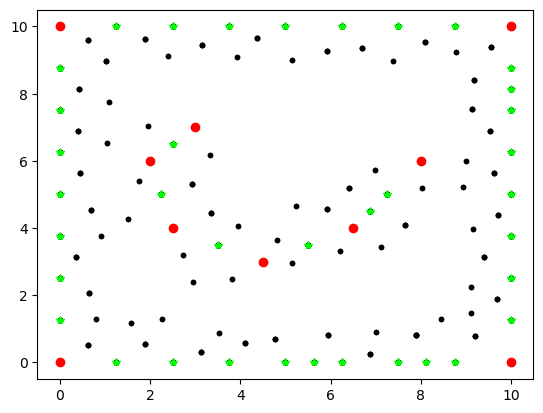

In [8]:
noneX = []
noneY = []

for tri in seg_tris:
    for v in tri:
        noneX.append(meshObj['vertices'][v][0])
        noneY.append(meshObj['vertices'][v][1])

plt.plot(noneX, noneY, '.', c=(0, 0, 0))
plt.plot(gx, gy, '*', c=(0,1,0))
plt.plot(rx, ry, 'o', c=(1,0,0))

In [15]:
vs = []
vms = []
for ver in all_dots_indexed:
    if ver in seg_vs:
        vs.append(all_dots_indexed[ver])
        vms.append(meshObj['vertex_markers'][ver])

In [23]:
st = np.array(seg_tris)
vvs = np.array(vs)
vvms = np.array(vms)
meshObj2 = dict(vertices=vs, vertex_markers=vvms, triangles=st, segments=meshObj['segments'], segment_markers=meshObj['segment_markers'])

In [27]:
len(meshObj2['segments'])

46

In [31]:
len(meshObj['segments'])

46

IndexError: index 144 is out of bounds for axis 0 with size 37

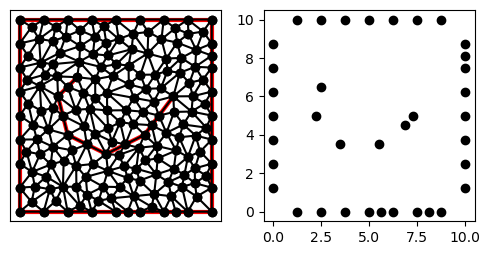

In [25]:
tr.compare(plt, meshObj, meshObj2)